In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
from joblib import Parallel, delayed
from math import floor, ceil
import os
import pickle

# Reading Each File

* title.basics: Contains basic information like titleName, genres, runtime, startYear, etc.
* title.ratings: Contains IMDb rating information for titles.
* title.crew: Contains list of directors and writers for each title
* title.principals: Contains list of the cast for each title
* names.basics: Contains basic information about a person like name, birthYear, deathYear, along with the titles they are most known for.
* title.akas: Contains information on the various versions/languages/regions a title is released in.

## Title Basics

In [14]:
## Load the data Title Basics
title_basics = pd.read_csv("title.basics.tsv", sep="\t", low_memory=False)

## Get some information overview
print(f"{title_basics.info()}")
print(f"{title_basics.head()}")
print(f"{title_basics.columns}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11497554 entries, 0 to 11497553
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 789.5+ MB
None
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      

### Filtering 

In [15]:
columns_needed = ["tconst", "titleType", "primaryTitle", "startYear", "genres"]
title_basics_filtered = title_basics[columns_needed]; title_basics_filtered.head()

,tconst,titleType,primaryTitle,startYear,genres
0,tt0000001,short,Carmencita,1894,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,1892,"Animation,Short"
2,tt0000003,short,Poor Pierrot,1892,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,1892,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,1893,Short


### Handling Null Values

In [16]:
#Perform some cleaning
title_basics_filtered = title_basics_filtered.dropna(subset=["primaryTitle"]) ##only 19 primary titles are missing
title_basics_filtered["genres"] = title_basics_filtered["genres"].fillna("unknown")

# Check for null values
null_values = title_basics_filtered.isnull().sum()
print(null_values)

tconst          0
titleType       0
primaryTitle    0
startYear       0
genres          0
dtype: int64


## Title Ratings 

In [17]:
title_ratings = pd.read_csv("title.ratings.tsv", sep="\t", low_memory=False)
title_ratings.isna().sum()

tconst           0
averageRating    0
numVotes         0
dtype: int64

### Merge with Title Basics and Title Ratings

In [10]:
movies = title_basics_filtered.merge(title_ratings, on="tconst", how="left")
movies_2023 = movies[movies["startYear"] == "2023"]  
movies_2023_filtered = movies_2023.dropna(subset=["numVotes", "averageRating"])
  
if movies_2023_filtered[movies_2023_filtered["startYear"] == "2023"].shape == movies_2023_filtered.shape:
    print(f"{ movies_2023_filtered[movies_2023_filtered["startYear"] == "2023"].shape == movies_2023_filtered.shape}, Matched!")
else:
    print(f"Did not matched")

True, Matched!


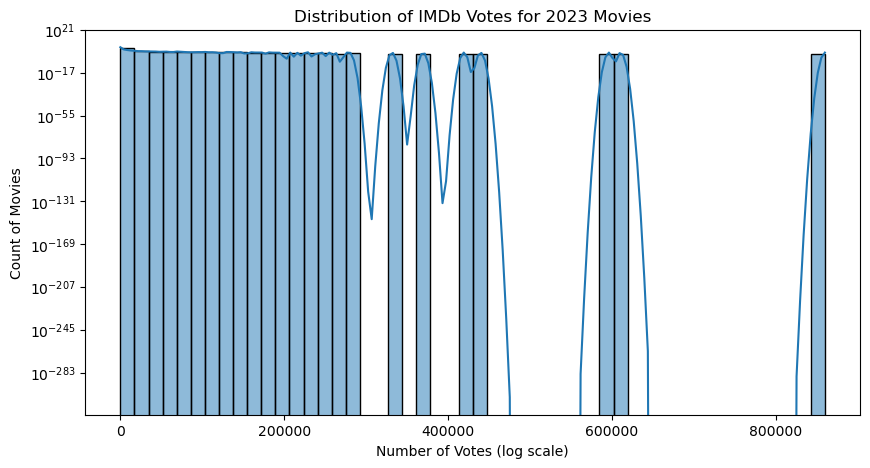

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of numVotes
plt.figure(figsize=(10,5))
sns.histplot(movies_2023_filtered["numVotes"], bins=50, kde=True)
# plt.xscale("log")  # Log scale to handle skewed data
plt.yscale("log")
plt.xlabel("Number of Votes (log scale)")
plt.ylabel("Count of Movies")
plt.title("Distribution of IMDb Votes for 2023 Movies")
plt.show()


In [8]:
percentiles = movies_2023["numVotes"].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(f"{percentiles}")

0.25      10.00
0.50      23.00
0.75      95.00
0.90     459.00
0.95    1213.45
0.99    9082.51
Name: numVotes, dtype: float64


$$
\mathbb{P}(R|v) = \frac{v}{v + m} R + \frac{m}{v + m} C
$$

where:

$$
\begin{aligned}
R &= \text{average rating of the movie} \\
v &= \text{number of votes for the movie} \\
m &= \text{minimum votes required for consideration} \\
C &= \text{mean rating across all qualifying movies}
\end{aligned}
$$


references
* Ranking Products Based on Bayesian Estimation of Ratings (J. M. Bernardo, 2003)
* Recommender Systems Handbook (Ricci, Rokach, & Shapira, 2015)

In [9]:
# highest_rated_movie2023 = movies_2023.sort_values(by="averageRating", ascending=False).iloc[0]; 
# print(f"Highest Rated Movie in 2023: {highest_rated_movie2023["primaryTitle"]}")
# print(f"Average Rating: {highest_rated_movie2023["averageRating"]}")
# print(f"Number of Votes: {highest_rated_movie2023["numVotes"]}")


# Step 1: Compute the Mean Rating Across All Movies
C = movies_2023["averageRating"].mean()

# Step 2: Set the Minimum Votes Threshold (90th percentile)
m = movies_2023["numVotes"].quantile(0.90)  ### >= 459 votes

# Step 3: Filter Movies with Enough Votes
qualified_movies = movies_2023[movies_2023["numVotes"] >= m]

# Step 4: Apply Weighted Rating (WR) Formula
def weighted_rating(df, m=m, C=C):
    v = df["numVotes"]
    R = df["averageRating"]
    return (v / (v + m) * R) + (m / (v + m) * C)

# Step 3: Create a Copy to Avoid Warning
qualified_movies = movies_2023[movies_2023["numVotes"] >= m].copy()

# Step 4: Apply Weighted Rating (WR) Formula
qualified_movies.loc[:, "WR"] = qualified_movies.apply(weighted_rating, axis=1)

# Step 5: Get the Top Movie Based on WR
highest_rated_movie2023 = qualified_movies.sort_values(by="WR", ascending=False).iloc[0]

print(f"Highest Rated Movie in 2023: {highest_rated_movie2023['primaryTitle']}")
print(f"Weighted Rating: {highest_rated_movie2023['WR']}")
print(f"Average Rating: {highest_rated_movie2023['averageRating']}")
print(f"Number of Votes: {highest_rated_movie2023['numVotes']}")


Highest Rated Movie in 2023: Connor's Wedding
Weighted Rating: 9.868963394322055
Average Rating: 9.9
Number of Votes: 39117.0


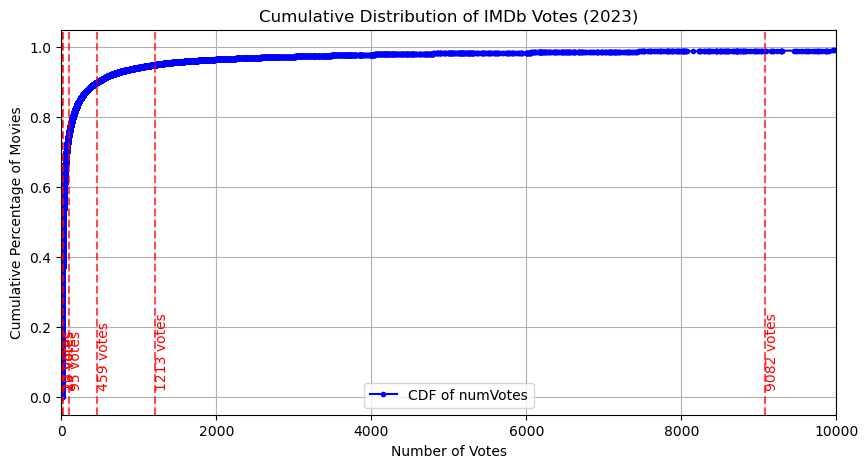

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Sort numVotes in ascending order
numVotes_sorted = np.sort(movies_2023_filtered["numVotes"])

# Compute CDF (cumulative percentage of movies)
cdf = np.arange(1, len(numVotes_sorted) + 1) / len(numVotes_sorted)

# Compute key percentiles
percentiles = movies_2023_filtered["numVotes"].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

# Plot CDF
plt.figure(figsize=(10,5))
plt.plot(numVotes_sorted, cdf, marker=".", linestyle="-", color="blue", label="CDF of numVotes")

# Mark key percentiles
for q in percentiles:
    plt.axvline(q, linestyle="dashed", color="red", alpha=0.7)
    plt.text(q, 0.02, f"{int(q)} votes", rotation=90, verticalalignment="bottom", color="red")

# Labels & Title
plt.xlabel("Number of Votes")
plt.ylabel("Cumulative Percentage of Movies")
plt.xlim(0,10000)
plt.title("Cumulative Distribution of IMDb Votes (2023)")
plt.grid(True)
plt.legend()

# Show plot
plt.show()


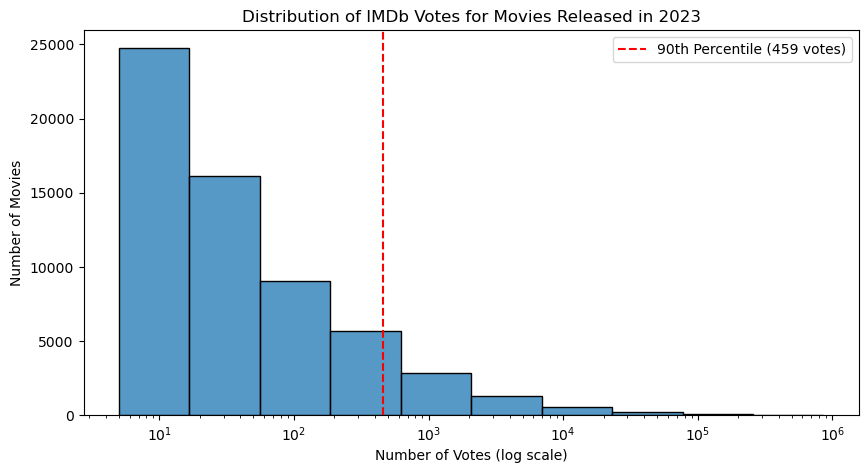

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(movies_2023_filtered["numVotes"], bins=10, log_scale=True)
plt.axvline(459, color='red', linestyle='dashed', label="90th Percentile (459 votes)")
plt.xlabel("Number of Votes (log scale)")
plt.ylabel("Number of Movies")
plt.title("Distribution of IMDb Votes for Movies Released in 2023")
plt.legend()
plt.show()


In [11]:
movie_highest_votes = movies_2023_filtered[movies_2023_filtered["numVotes"] == np.max(movies_2023_filtered["numVotes"])]
movie_highest_votes["primaryTitle"]

3904984    Oppenheimer
Name: primaryTitle, dtype: object

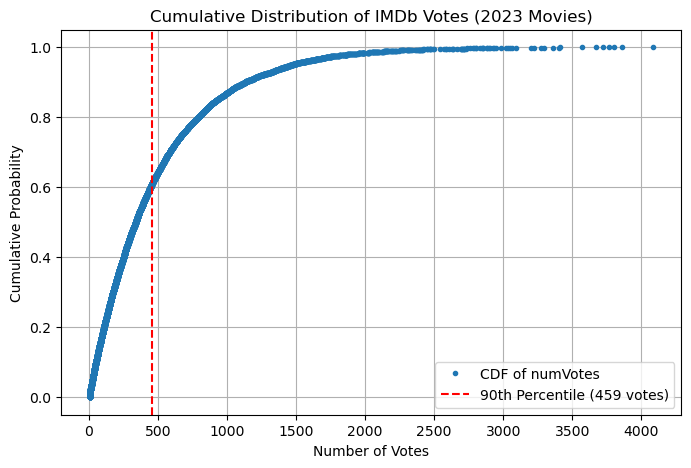

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated vote data (since I don't have access to the full dataset)
# Replace this with your actual `movies_2023_filtered["numVotes"]` data
np.random.seed(42)
num_votes = np.random.exponential(scale=500, size=10000)  # Simulating a skewed vote distribution
num_votes = np.clip(num_votes, 5, 10000)  # Clamping values to a reasonable range

# Sort votes for cumulative distribution
votes_sorted = np.sort(num_votes)

# Compute cumulative distribution
cdf = np.arange(len(votes_sorted)) / len(votes_sorted)

plt.figure(figsize=(8,5))
plt.plot(votes_sorted, cdf, marker=".", linestyle="none", label="CDF of numVotes")
plt.axvline(x=459, color="r", linestyle="--", label="90th Percentile (459 votes)")
plt.xlabel("Number of Votes")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of IMDb Votes (2023 Movies)")
plt.legend()
plt.grid()
plt.show()


## Title Crew

In [5]:
title_crew = pd.read_csv("title.crew.tsv", sep="\t", low_memory=False)

## Name Basics

In [1]:
filtered_data_name_basic = []

for chunk in pd.read_csv("name.basics.tsv", sep="\t", chunksize=10000):
    filtered_data_name_basic.append(chunk)


name_basic = pd.concat(filtered_data_name_basic, ignore_index=True)

NameError: name 'pd' is not defined

## Title Principals

In [ ]:
filtered_data = []

# Read the file in chunks
chunk_size = 10000  # Adjust the chunk size based on your memory capacity
for chunk in pd.read_csv("title.principals.tsv", sep='\t', chunksize=chunk_size, low_memory=False):
    filtered_data.append(chunk)

# Concatenate the filtered chunks into a single DataFrame
title_principals = pd.concat(filtered_data, ignore_index=True)